# Audible Data Science technical challenge

## Movie Rating Prediction using IMDB Datasets

Use the publicly available IMDB Datasets to build a model that predicts a movie’s average rating.

### 1. Data Gathering

> The dataset files can be accessed and downloaded from https://datasets.imdbws.com/. The data is refreshed daily.

Web-scraping the datasets from the dataset page and storing them in the `data` folder.

In [ ]:
import os
import requests

In [ ]:
# !pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
url = "https://datasets.imdbws.com"
folder = "data"

In [ ]:
# Make the data directory if it doesn't exist
if not os.path.isdir(folder):
    os.mkdir(folder)

# Send request
response = requests.get(url)
response.raise_for_status()  # Raise exception if invalid response

# Parse HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find and download all datasets
for link in soup.find_all('a'):
    href = link.get('href')
    if href.endswith('.tsv.gz'):
        print(f"Downloading {href} ...")

        # Send request
        r = requests.get(href, stream=True)
        r.raise_for_status()  # Raise exception if invalid response

        # Download to file
        with open(os.path.join(folder, os.path.basename(href)), 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

print("Download completed!")

Download completed!


### 2. Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np

#### Load the data

> Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A `\N` is used to denote that a particular field is missing or null for that title/name.

Loading only few datasets because of resource limitations.

In [ ]:
title_basics = pd.read_csv('data/title.basics.tsv.gz', sep='\t', na_values='\\N')
title_basics.head()

<ipython-input-7-14af40f4879b>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv('data/title.basics.tsv.gz', sep='\t', na_values='\\N')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short"


In [ ]:
title_ratings = pd.read_csv('data/title.ratings.tsv.gz', sep='\t', na_values='\\N')
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1990
1,tt0000002,5.8,265
2,tt0000003,6.5,1853
3,tt0000004,5.5,178
4,tt0000005,6.2,2638


#### Merge datasets

In [ ]:
titles = title_basics.merge(title_ratings, on='tconst')
titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short",5.7,1990
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short",5.8,265
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance",6.5,1853
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short",5.5,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short",6.2,2638


#### Filter the relevant data

Checking the types of titles in the dataset

In [ ]:
# Get counts of each title type
titles['titleType'].value_counts()

tvEpisode       656861
movie           294874
short           149255
tvSeries         88684
tvMovie          50950
video            50567
tvMiniSeries     15334
videoGame        14951
tvSpecial        11314
tvShort           2169
Name: titleType, dtype: int64

Not all titles are movies. Therefore, filtering the data to include only movies (`titleType` is 'movie')

Assuming, we are predicting only for movies (not considering `tvMovie`)

In [ ]:
movies = titles[titles['titleType'] == 'movie']
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,NaN,45.0,Romance,5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,NaN,100.0,"Documentary,News,Sport",5.3,481
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN,4.1,15
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography",6.0,841
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama,4.4,20


Checking for the type of features and null values

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294874 entries, 8 to 1334954
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          294874 non-null  object 
 1   titleType       294874 non-null  object 
 2   primaryTitle    294874 non-null  object 
 3   originalTitle   294874 non-null  object 
 4   isAdult         294874 non-null  float64
 5   startYear       294839 non-null  float64
 6   endYear         0 non-null       float64
 7   runtimeMinutes  265808 non-null  object 
 8   genres          284745 non-null  object 
 9   averageRating   294874 non-null  float64
 10  numVotes        294874 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 27.0+ MB


#### Handling null values

In [ ]:
movies.isnull().sum()

tconst                 0
titleType              0
primaryTitle           0
originalTitle          0
isAdult                0
startYear             35
endYear           294874
runtimeMinutes     29066
genres             10129
averageRating          0
numVotes               0
dtype: int64

Missing values are present in four features
1. `startYear`
2. `endYear`
3. `runtimeMinutes`
4. `genres`

`startYear`: Since there are very few missing values in this column, we can fill them with the median of the rest of the column



In [ ]:
movies['startYear'] = movies['startYear'].fillna(movies['startYear'].median())

<ipython-input-14-4c890e63ad4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['startYear'] = movies['startYear'].fillna(movies['startYear'].median())


`endYear`: This column has no non-null values at all. It's likely this field is not useful for the prediction, let's drop the feature



In [ ]:
movies = movies.drop(columns='endYear')

In [ ]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,Romance,5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"Documentary,News,Sport",5.3,481
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.1,15
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"Action,Adventure,Biography",6.0,841
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,Drama,4.4,20


`runtimeMinutes`: Fill in the missing values with the median

I realized that the field is an object type, which suggests it might contain non-numeric values. We need to convert it to a numeric type, and then impute accordingly.

In [ ]:
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')
movies['runtimeMinutes'] = movies['runtimeMinutes'].fillna(movies['runtimeMinutes'].median())

`genres`: There are several strategies to handle the missing values in this column:
1. Fill them with a placeholder value like 'Unknown'
2. Fill them with the top 3 genres of the directors of the movie

In [ ]:
unknown_genre_count_before_imputing = movies['genres'].isnull().sum()
print(f"Number of ['Unknown'] in genres: {unknown_genre_count_before_imputing}")

Number of ['Unknown'] in genres: 10129


~~Going with the first option since it is easy~~

In [ ]:
# movies['genres'] = movies['genres'].fillna('Unknown')

**_~~If I had more time and resources~~_**, I ~~would~~ choose the second option.


**Strategy**:

We are filling in missing genres for movies based on the favorite genres of their directors.

For example, let's say we have a movie with missing genre information and this movie is directed by two directors.

Director 1 is known for making Comedy, Drama, and Romance movies.
Director 2 is known for making Action, Comedy, and Sci-Fi movies.
To fill in the missing genre for this movie, we'll look at what both directors are known for. Comedy appears for both directors, so it's a likely genre for this movie. Next is Drama from Director 1 and Action from Director 2. So, we fill in the missing genre as Comedy, Drama, and Action.

If we don't know anything about the directors, or they haven't made any other movies to judge their favorite genres, we fill in the genre as 'Unknown'.


How did I do this?

1. Created a dictionary (`directors_genres`) mapping each director to their top 3 genres.
2. For each movie with missing genres, checked its directors. For these directors, got their top genres from `directors_genres`.
3. Compiled a list of these top genres and picked the 3 most common genres to fill in for the movie's missing genres.

In [ ]:
title_crew = pd.read_csv('data/title.crew.tsv.gz', sep='\t', na_values='\\N')

title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [ ]:
# Merge with 'title_crew' to get the directors' info:
movies = pd.merge(movies, title_crew[['tconst', 'directors']], on='tconst')

movies.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,Romance,5.3,206,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"Documentary,News,Sport",5.3,481,nm0714557
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.1,15,nm0063413
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"Action,Adventure,Biography",6.0,841,nm0846879
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,Drama,4.4,20,nm0141150
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,91.0,Drama,4.3,24,nm0533958
6,tt0000630,movie,Hamlet,Amleto,0.0,1908.0,91.0,Drama,2.8,26,nm0143333
7,tt0000675,movie,Don Quijote,Don Quijote,0.0,1908.0,91.0,Drama,4.2,20,nm0194088
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908.0,120.0,"Adventure,Fantasy",5.1,68,"nm0091767,nm0877783"
9,tt0000862,movie,Faldgruben,Faldgruben,0.0,1909.0,91.0,NaN,4.4,17,nm0878467


In [ ]:
# Convert directors and genres into lists
movies['directors'] = movies['directors'].str.split(',')
movies['genres'] = movies['genres'].str.split(',')

In [ ]:
movies.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206,[nm0085156]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,481,[nm0714557]
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.1,15,[nm0063413]
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,841,[nm0846879]
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20,[nm0141150]
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,91.0,[Drama],4.3,24,[nm0533958]
6,tt0000630,movie,Hamlet,Amleto,0.0,1908.0,91.0,[Drama],2.8,26,[nm0143333]
7,tt0000675,movie,Don Quijote,Don Quijote,0.0,1908.0,91.0,[Drama],4.2,20,[nm0194088]
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908.0,120.0,"[Adventure, Fantasy]",5.1,68,"[nm0091767, nm0877783]"
9,tt0000862,movie,Faldgruben,Faldgruben,0.0,1909.0,91.0,NaN,4.4,17,[nm0878467]


In [ ]:
# Prepare a mapping of directors to their top 3 genres
directors_genres = movies.explode('directors').dropna(subset=['directors', 'genres']).groupby('directors')['genres'].sum()
directors_genres = directors_genres.apply(lambda genres: pd.Series(genres).value_counts().index[:3].tolist())

In [ ]:
directors_genres.head(15)

directors
nm0000005       [Drama, Romance, Comedy]
nm0000008               [Drama, Western]
nm0000009       [Drama, Horror, Mystery]
nm0000010      [Crime, Drama, Film-Noir]
nm0000018           [Western, Adventure]
nm0000019       [Drama, Comedy, Fantasy]
nm0000024                        [Drama]
nm0000032    [Drama, History, Adventure]
nm0000033     [Thriller, Drama, Mystery]
nm0000036      [Comedy, Romance, Action]
nm0000037     [Comedy, Musical, Romance]
nm0000040            [Drama, War, Crime]
nm0000041     [Drama, Action, Adventure]
nm0000044     [Drama, Action, Adventure]
nm0000045    [Action, Adventure, Comedy]
Name: genres, dtype: object

In [ ]:
def impute_genres(row):
    # Check if genres list is empty or contains only None values
    if row['genres'] is np.nan:
        # Check if 'directors' is not NaN
        if row['directors'] is not np.nan:
            genres = [directors_genres[director] for director in row['directors'] if director in directors_genres]
            genres = [item for sublist in genres for item in sublist]  # flatten the list of lists
            # Calculate the frequency of each genre and select the top 3
            genres = pd.Series(genres, dtype='object').value_counts().index[:3].tolist()
            return genres if genres else ['Unknown']
        else:
            return ['Unknown']
    else:
        return row['genres']

In [ ]:
movies.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206,[nm0085156]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,481,[nm0714557]
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.1,15,[nm0063413]
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,841,[nm0846879]
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20,[nm0141150]
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,91.0,[Drama],4.3,24,[nm0533958]
6,tt0000630,movie,Hamlet,Amleto,0.0,1908.0,91.0,[Drama],2.8,26,[nm0143333]
7,tt0000675,movie,Don Quijote,Don Quijote,0.0,1908.0,91.0,[Drama],4.2,20,[nm0194088]
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908.0,120.0,"[Adventure, Fantasy]",5.1,68,"[nm0091767, nm0877783]"
9,tt0000862,movie,Faldgruben,Faldgruben,0.0,1909.0,91.0,NaN,4.4,17,[nm0878467]


In [ ]:
def impute_genres_test(directors):
    genres = [directors_genres[director] for director in directors if director in directors_genres]
    genres = [item for sublist in genres for item in sublist]  # flatten the list of lists
    # Calculate the frequency of each genre and select the top 3
    genres = pd.Series(genres, dtype='object').value_counts().index[:3].tolist()
    return genres

In [ ]:
print('nm0063413', directors_genres.get('nm0063413', 'director has no record'))
print('nm0878467', directors_genres.get('nm0878467', 'director has no record'))
print('nm0185426', directors_genres.get('nm0185426', 'director has no record'))

nm0063413 ['Drama', 'Adventure']
nm0878467 director has no record
nm0185426 director has no record


In [ ]:
print('nm0091767', directors_genres.get('nm0091767', 'director has no record'))
print('nm0877783', directors_genres.get('nm0877783', 'director has no record'))
impute_genres_test(['nm0091767', 'nm0877783'])

nm0091767 ['Adventure', 'Fantasy']
nm0877783 ['Adventure', 'Drama', 'Fantasy']


['Adventure', 'Fantasy', 'Drama']

In [ ]:
# Apply the function
movies['genres'] = movies.apply(impute_genres, axis=1)

In [ ]:
movies.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206,[nm0085156]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,481,[nm0714557]
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,"[Drama, Adventure]",4.1,15,[nm0063413]
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,841,[nm0846879]
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20,[nm0141150]
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,91.0,[Drama],4.3,24,[nm0533958]
6,tt0000630,movie,Hamlet,Amleto,0.0,1908.0,91.0,[Drama],2.8,26,[nm0143333]
7,tt0000675,movie,Don Quijote,Don Quijote,0.0,1908.0,91.0,[Drama],4.2,20,[nm0194088]
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908.0,120.0,"[Adventure, Fantasy]",5.1,68,"[nm0091767, nm0877783]"
9,tt0000862,movie,Faldgruben,Faldgruben,0.0,1909.0,91.0,[Unknown],4.4,17,[nm0878467]


In [ ]:
movies.isnull().sum()

tconst               0
titleType            0
primaryTitle         0
originalTitle        0
isAdult              0
startYear            0
runtimeMinutes       0
genres               0
averageRating        0
numVotes             0
directors         3469
dtype: int64

In [ ]:
unknown_genre_count_after_imputing = movies[movies['genres'].apply(lambda x: x == ['Unknown'])].shape[0]
print(f"Number of ['Unknown'] in genres: {unknown_genre_count_after_imputing}")

Number of ['Unknown'] in genres: 2955


In [ ]:
print(f"Number of missing genres imputed: {unknown_genre_count_before_imputing - unknown_genre_count_after_imputing}")

Number of missing genres imputed: 7174


Dropping `directors` column since it is not relevant anymore.

In [ ]:
movies = movies.drop(columns='directors')

In [ ]:
movies.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,481
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,"[Drama, Adventure]",4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,841
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,91.0,[Drama],4.3,24
6,tt0000630,movie,Hamlet,Amleto,0.0,1908.0,91.0,[Drama],2.8,26
7,tt0000675,movie,Don Quijote,Don Quijote,0.0,1908.0,91.0,[Drama],4.2,20
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908.0,120.0,"[Adventure, Fantasy]",5.1,68
9,tt0000862,movie,Faldgruben,Faldgruben,0.0,1909.0,91.0,[Unknown],4.4,17


In [ ]:
movies.isnull().sum()

tconst            0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

### 3. Exploratory Data Analysis

Let's find some answers to some of the questions using the plots and the data.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
movies.describe()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes
count,294874.000000,294874.000000,294874.000000,294874.000000,2.948740e+05
mean,0.015654,1994.794312,94.094980,6.176944,3.612252e+03
std,0.124134,25.818217,132.051884,1.368163,3.547450e+04
min,0.000000,1894.000000,1.000000,1.000000,5.000000e+00
25%,0.000000,1979.000000,83.000000,5.400000,1.900000e+01
50%,0.000000,2005.000000,91.000000,6.300000,6.100000e+01
75%,0.000000,2015.000000,101.000000,7.100000,3.120000e+02
max,1.000000,2023.000000,51420.000000,10.000000,2.777285e+06


#### Correlation plot

<ipython-input-41-5cb789cce20a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = movies.corr()


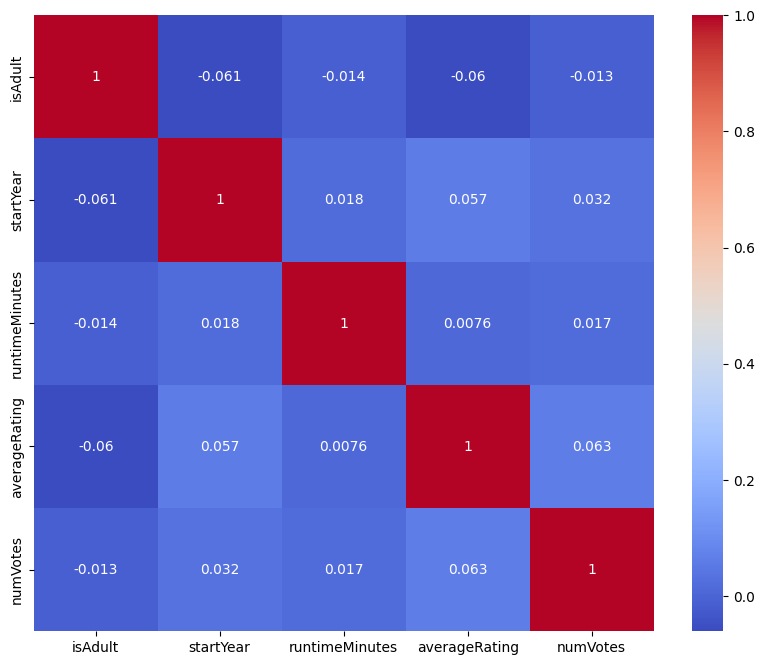

In [ ]:
plt.figure(figsize=(10,8))
correlation_matrix = movies.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix, we can infer that

`isAdult` and `averageRating`: 'adult' movies tend to have slightly lower ratings, although the relationship is weak.

`startYear` and `averageRating`: more recent movies have slightly higher ratings, but again, this is a weak correlation.

`runtimeMinutes` and `averageRating`: longer movies might have slightly higher ratings, but the relationship is quite weak.

`numVotes` and `averageRating`: movies with more votes tend to have slightly higher ratings, although the correlation is weak.

#### Assumption 1. 'adult' movies tend to have slightly lower ratings

Is there a difference in average ratings between movies classified as 'adult' and those that are not?

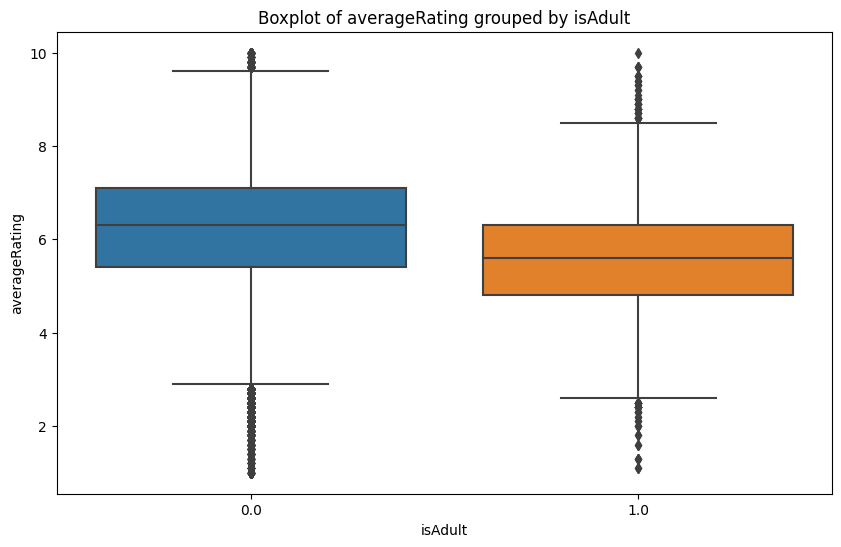

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='isAdult', y='averageRating', data=movies)
plt.title('Boxplot of averageRating grouped by isAdult')
plt.xlabel('isAdult')
plt.ylabel('averageRating')
plt.show()

In the box plot, the line in the middle of each box is the median rating for that category, while the box extends from the lower to upper quartile values of the data, giving the interquartile range. The whiskers extend to show the range of the data, and points outside of this range are considered to be outliers.

The medians and/or interquartile ranges differ significantly between the adult and non-adult movies, this could indicate a correlation between the `isAdult` and the `averageRating`.

#### Assumption 2. `averageRating` is normally distributed

What is the distribution of the average ratings? Are most movies rated moderately or are there extremes?

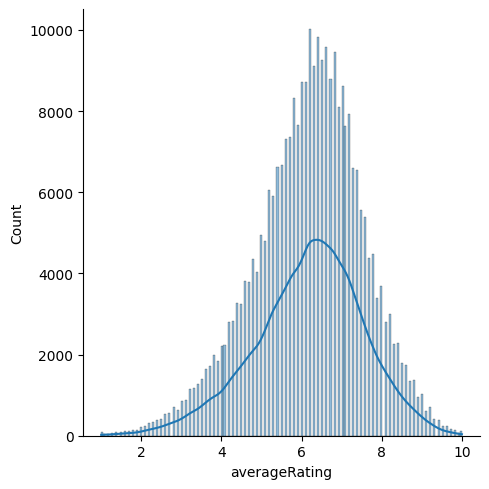

In [ ]:
# create a histogram of averageRating
sns.displot(movies['averageRating'], kde=True)
plt.show()

`averageRating` is normally distributed. This implies that most movies receive a moderate rating, with few movies getting very low or very high ratings.

#### Assumption 3. `genres` affect the `averageRating`

Are certain genres more highly rated than others?

In [ ]:
# explode genres on movies
movies_exploded = movies.assign(genres=movies['genres']).explode('genres')

In [ ]:
movies_exploded.head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,Romance,5.3,206
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,Documentary,5.3,481
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,News,5.3,481
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,Sport,5.3,481
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,Drama,4.1,15
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,Adventure,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,Action,6.0,841
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,Adventure,6.0,841
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,Biography,6.0,841
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,Drama,4.4,20


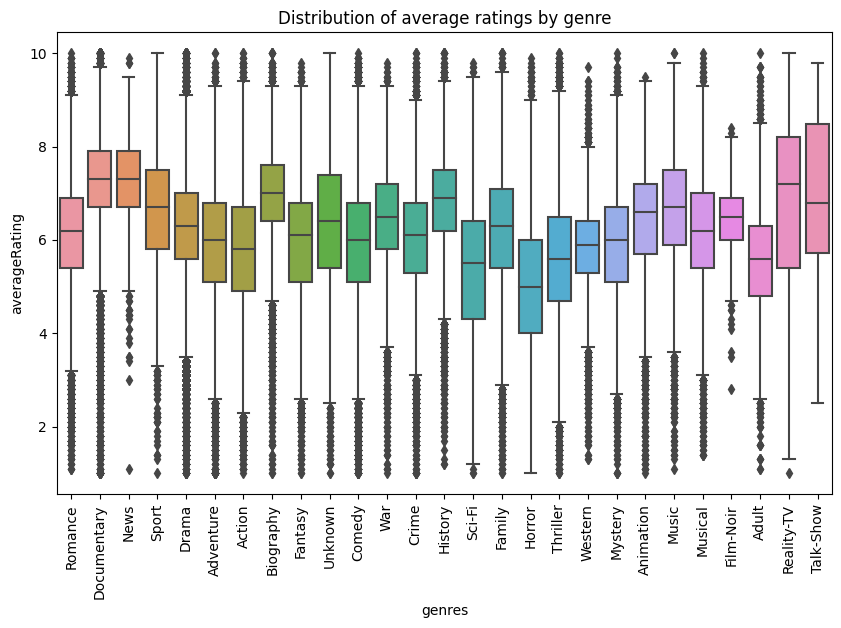

In [ ]:
# box plot for avgRatings for each genre
plt.figure(figsize=(10,6))
sns.boxplot(x='genres', y='averageRating', data=movies_exploded)
plt.xticks(rotation=90)
plt.title('Distribution of average ratings by genre')
plt.show()

Based on this plot, there are some genres that have high score than others, which mean that genre definitely affect the movie rating.

**_If I had more time and resources_**, I would perform some more analysis on the featues and their relationships to answer a few more questions
4. Is there a trend or noticeable pattern between the release year of a movie and its average rating?
5. Does the length of a movie (runtime) influence its average rating? Are longer or shorter movies rated more highly?
6. Does the popularity of a movie (as measured by the number of votes) correlate with its average rating? Do more popular movies tend to have higher ratings?

### 4. Feature Engineering

#### One-hot encoding of Genres

Since we know that `genre` has an effect on the `averageRating`, let's use it as a feature but Machine learning models cannot work with categorical data, they require numerical inputs. We need to encode the `genres` into a numeric format. We can use one-hot encoding.

The disadvantage of this process is it increases the dataset's size (adds more features).

Use `MultiLabelBinarizer` for one-hot encoding

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encoding of genres
one_hot_genres = mlb.fit_transform(movies['genres'])

# Convert this array into a DataFrame
one_hot_genres_df = pd.DataFrame(one_hot_genres, columns=mlb.classes_)

one_hot_genres_df.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,Unknown,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert this array into a DataFrame and rename the columns
one_hot_genres_df = pd.DataFrame(one_hot_genres, columns=['genre_'+str(cls) for cls in mlb.classes_])

In [ ]:
one_hot_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294874 entries, 0 to 294873
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   genre_Action       294874 non-null  int64
 1   genre_Adult        294874 non-null  int64
 2   genre_Adventure    294874 non-null  int64
 3   genre_Animation    294874 non-null  int64
 4   genre_Biography    294874 non-null  int64
 5   genre_Comedy       294874 non-null  int64
 6   genre_Crime        294874 non-null  int64
 7   genre_Documentary  294874 non-null  int64
 8   genre_Drama        294874 non-null  int64
 9   genre_Family       294874 non-null  int64
 10  genre_Fantasy      294874 non-null  int64
 11  genre_Film-Noir    294874 non-null  int64
 12  genre_History      294874 non-null  int64
 13  genre_Horror       294874 non-null  int64
 14  genre_Music        294874 non-null  int64
 15  genre_Musical      294874 non-null  int64
 16  genre_Mystery      294874 non-null  in

In [ ]:
# Reset index of your main DataFrame and construct final DataFrame
movies.reset_index(drop=True, inplace=True)
movies = pd.concat([movies, one_hot_genres_df], axis=1)

movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206,...,0,0,1,0,0,0,0,0,0,0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,481,...,1,0,0,0,1,0,0,0,0,0
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,"[Drama, Adventure]",4.1,15,...,0,0,0,0,0,0,0,0,0,0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,841,...,0,0,0,0,0,0,0,0,0,0
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294874 entries, 0 to 294873
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             294874 non-null  object 
 1   titleType          294874 non-null  object 
 2   primaryTitle       294874 non-null  object 
 3   originalTitle      294874 non-null  object 
 4   isAdult            294874 non-null  float64
 5   startYear          294874 non-null  float64
 6   runtimeMinutes     294874 non-null  float64
 7   genres             294874 non-null  object 
 8   averageRating      294874 non-null  float64
 9   numVotes           294874 non-null  int64  
 10  genre_Action       294874 non-null  int64  
 11  genre_Adult        294874 non-null  int64  
 12  genre_Adventure    294874 non-null  int64  
 13  genre_Animation    294874 non-null  int64  
 14  genre_Biography    294874 non-null  int64  
 15  genre_Comedy       294874 non-null  int64  
 16  ge

#### Dimensionality reduction

As of now, we are removing the redundant features

_**If I had more time and resources**_, I would perform Principal Component Analysis (PCA) to improve the performance of models

In [ ]:
movies = movies.drop(columns='genres')

In [ ]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genre_Action,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,5.3,206,0,...,0,0,1,0,0,0,0,0,0,0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,5.3,481,0,...,1,0,0,0,1,0,0,0,0,0
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,4.1,15,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,6.0,841,1,...,0,0,0,0,0,0,0,0,0,0
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,4.4,20,0,...,0,0,0,0,0,0,0,0,0,0


**_If I had more time and resources_**, I would explore the crew features by loading the other datasets. Create indicators for specific directors, writers or crew members who may be particularly influential.

This can be done by one-hot encoding the directors and writers columns. This, however, might result in a high dimensional data problem, so another approach might be to create a success score/popularity index for directors and writers based on the average ratings of their past movies. This can be treated as a measure of their past performance.

Similar to the success score/popularity index for directors and writers, you can create a measure of the success of the main actors/actresses based on the ratings of their past movies.

### 5. Model Training and Evaluation

Now that we have a proper dataset, we will be training and few models and testing them on unseen data to see how do they perform.

In [ ]:
movies.set_index('tconst', inplace=True)

In [ ]:
movies.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genre_Action,genre_Adult,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,5.3,206,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,5.3,481,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,4.1,15,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,6.0,841,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,4.4,20,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Get the list of columns and rearrange them
cols = movies.columns.tolist()
cols.remove('averageRating')
cols.insert(cols.index('originalTitle') + 1, 'averageRating')

# Reindex the dataframe
movies = movies[cols]

In [ ]:
movies.head()

,titleType,primaryTitle,originalTitle,averageRating,isAdult,startYear,runtimeMinutes,numVotes,genre_Action,genre_Adult,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,5.3,0.0,1894.0,45.0,206,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,5.3,0.0,1897.0,100.0,481,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,movie,Bohemios,Bohemios,4.1,0.0,1905.0,100.0,15,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,6.0,0.0,1906.0,70.0,841,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,4.4,0.0,1907.0,90.0,20,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = movies.loc[:, 'isAdult':]

features.head()

,isAdult,startYear,runtimeMinutes,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,0.0,1894.0,45.0,206,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,0.0,1897.0,100.0,481,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,0.0,1905.0,100.0,15,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,0.0,1906.0,70.0,841,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,0.0,1907.0,90.0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target = movies['averageRating']

target.head()

tconst
tt0000009    5.3
tt0000147    5.3
tt0000502    4.1
tt0000574    6.0
tt0000591    4.4
Name: averageRating, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# instantiate and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# make predictions
y_pred_lr = lr.predict(X_test)

# compute metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print('Linear Regression:')
print('MSE:', mse_lr)
print('RMSE:', rmse_lr)
print('MAE:', mae_lr)
print('R²:', r2_lr)

Linear Regression:
MSE: 1.5127452264335703
RMSE: 1.2299370823068838
MAE: 0.9464760194723165
R²: 0.19293616686751058


The Linear Regression model isn't performing very well, the MSE, RMSE, and MAE are fairly high. The low R² score suggests that there may be a non-linear relationship between some of the features and the target variable, which the LR model can't capture.

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# instantiate and train the model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# make predictions
y_pred_dt = dt.predict(X_test)

# compute metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)

print('\nDecision Tree:')
print('MSE:', mse_dt)
print('RMSE:', rmse_dt)
print('MAE:', mae_dt)
print('R²:', r2_dt)


Decision Tree:
MSE: 2.577107403599305
RMSE: 1.6053371619691936
MAE: 1.223597362832166
R²: -0.37491108429837583


The Decision Tree model seems to be performing worse than the Linear Regression model. The negative R² score for the Decision Tree model indicates that it is performing worse than a horizontal line fit to the data.

#### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# instantiate and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# make predictions
y_pred_rf = rf.predict(X_test)

# compute metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print('\nRandom Forest:')
print('MSE:', mse_rf)
print('RMSE:', rmse_rf)
print('MAE:', mae_rf)
print('R²:', r2_rf)


Random Forest:
MSE: 1.440080408477926
RMSE: 1.2000335030647795
MAE: 0.9114137954135759
R²: 0.2317035319785664


The Random Forest model is performing better than both the other models. This suggests that Random Forest is a more suitable model for the dataset as it is able to capture more complex relationships between the features and the target variable.




However, the performance of the Random Forest model can still be improved by tuning the parameters, feature engineering, etc.

The optimal values for `n_estimators`, `max_features`, and `min_samples_leaf` really depend on the specifics of the dataset. The best approach to find these optimal hyperparameters is to use a Grid Search. This will test all combinations of the provided parameter values, fit a model for each combination, and then report the parameters that gave the best performance.

```py
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4, 10, 50]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
```
```bash
{'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
```

In [ ]:
from math import sqrt
# instantiate and train the model
rf = RandomForestRegressor(
    max_features = 'sqrt',
    min_samples_leaf = 4,
    n_estimators = 1000
    )
rf.fit(X_train, y_train)

# make predictions
y_pred_rf = rf.predict(X_test)

# compute metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print('\nRandom Forest (after parameter tuning):')
print('MSE:', mse_rf)
print('RMSE:', rmse_rf)
print('MAE:', mae_rf)
print('R²:', r2_rf)


Random Forest (after parameter tuning):
MSE: 1.2923175164890517
RMSE: 1.1368014411008862
MAE: 0.8665686367517339
R²: 0.3105364272470147


### 6. Conclusion

Random Forests (after parameter tuning) gave the best results.

| Model | MSE | RMSE | MAE | R² |
|---|---|---|---|---|
| Linear Regression | 1.5127 | 1.2299 | 0.9465 | 0.1929 |
| Decision Tree | 2.5771 | 1.6053 | 1.2236 | -0.3749 |
| Random Forest | 1.4401 | 1.2000 | 0.9114 | 0.2317 |
| Random Forest (after tuning) | 1.2923 | 1.1368 | 0.8666 | 0.3105 |


_**If I had more time time and resource**_, I would experiment with more models and/or ensembles of models like Neural Networks, XGBoost, etc. I could also do more extensive hyperparameter tuning, spend more time on feature engineering.

#### Who would use your model?

The model developed can be leveraged by any online media streaming platforms such as Amazon Prime, etc., to predict movie ratings, allowing them to offer personalized suggestions to their users. Similarly, Audible can use a model based on the same lines to predict ratings for audiobooks. This predictive model can assist in better understanding user preferences, in turn leading to a curated, personalized listening experience for Audible users.

#### What might they find surprising?

It might be surprising to find that features like 'isAdult' and the 'genres' of a movie or audiobook have a significant influence on the ratings. For instance, certain genres might consistently receive higher or lower ratings, indicating specific preferences among the audience. It can lead to valuable insights into user behavior and preferences, and may assist in strategic decision-making such as which new content to add or promote.

#### How confident would you be in your model predictions?

Currently, the best model (Random Forest, after hyperparameter tuning) has an R² value of around 0.31. While this shows that our model is capturing some of the patterns in the data, it also indicates there is substantial room for improvement. Therefore, while I would consider the predictions of this model as a valuable part of the decision-making process, I would also advise supplementing the model's predictions with other sources of information.

#### How does it align with Audible's People's Principles?

This project fits well with Audible's People's Principles:

- **Be Customer Obsessed**: The model is aimed at enhancing user experience through personalized suggestions, epitomizing a customer-centric approach.
- **Imagine & Invent Before They Ask**: By predicting ratings, we are anticipating customer preferences before they explicitly state them.
- **Articulate The Possible & Move Fast To Make It Real**: We have identified a potential enhancement to the user experience (predicted, personalized ratings), developed a prototype model, and laid out a roadmap for further improvements.
- **Study & Draw Inspiration From Culture & Technology**: This work draws heavily on modern data science technology and is aimed at understanding cultural trends through the lens of book and movie ratings.
- **Activate Caring**: By working to improve the user experience, we are demonstrating that we care about our customers and their satisfaction with our platform.